In [4]:
%run bidirectional_LSTM_functions.ipynb

C:\Users\Sumi\Anaconda3\envs\NLP\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


## Load and Clean data
Data: The Republic by Plato
http://www.gutenberg.org/cache/epub/1497/pg1497.txt

In [5]:
ROOT = "C:/Users/Sumi/Desktop/NOTES SEM2/NLP/Internship at RiskConcile/Bidirectiona-LSTM-for-text-summarization--master"

In [6]:
# load document
in_filename = ROOT+'/republic_clean.txt'
doc = load_doc(in_filename)
# print(doc[:20])

In [3]:
# clean document
tokens = clean_doc(doc)
# print(tokens[:20])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = ROOT + '/republic_sequences.txt'
save_doc(sequences, out_filename)

Total Tokens: 118683
Unique Tokens: 7409
Total Sequences: 118632


## Train Language Model

### Load Sequences

In [4]:
# load
in_filename = ROOT+'/republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')


### Encode Sequences

In [5]:

'''Using Tokenizer class in the Keras API.
First, the Tokenizer must be trained on the entire training dataset, 
which means it finds all of the unique words in the data and assigns each a unique integer.
We can then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of words 
to a list of integers.
'''
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)


We can access the mapping of words to integers as a dictionary attribute called word_index on the Tokenizer object.
We need to know the size of the vocabulary for defining the embedding layer later. We can determine the vocabulary by calculating the size of the mapping dictionary.
The Embedding layer needs to allocate a vector representation for each word in this vocabulary from index 1 to the largest index 

In [6]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7410

### Sequence Inputs and Output

In [7]:
'''
- Array slicing done to separate the input sequences into input (X) and output (y) elements.
- We then one hot encode the output word. 
  This means converting it from an integer to a vector of 0 values, one for each word in the vocabulary, 
  with a 1 to indicate the specific word at the index of the words integer value.
  
'''
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1] # to specify to the Embedding layer how long input sequences are.
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]
seq_length

50

### Fit Model

We will use a two LSTM hidden layers with 100 memory cells each. More memory cells and a deeper network may achieve better results.

A dense fully connected layer with 100 neurons connects to the LSTM hidden layers to interpret the features extracted from the sequence. The output layer predicts the next word as a single vector the size of the vocabulary with a probability for each word in the vocabulary. A softmax activation function is used to ensure the outputs have the characteristics of normalized probabilities.

In [8]:
# define model
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, 50, input_length=seq_length))
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(vocab_size, activation='softmax'))
print(lstm_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            370500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 7410)              748410    
Total params: 1,269,810
Trainable params: 1,269,810
Non-trainable params: 0
_________________________________________________________________
None


Next, the model is compiled specifying the categorical cross entropy loss needed to fit the model. Technically, the model is learning a multi-class classification and this is the suitable loss function for this type of problem.

The efficient Adam implementation to mini-batch gradient descent is used and accuracy is evaluated of the model.

Finally, the model is fit on the data for 100 training epochs with a modest batch size of 128 to speed things up.


In [16]:
# compile model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
epochs = 20
history = lstm_model.fit(X, y, batch_size=512, epochs=epochs)

Epoch 1/20
118632/118632 [==============================] - 352s 3ms/step - loss: 5.2642 - acc: 0.1540
Epoch 2/20
118632/118632 [==============================] - 329s 3ms/step - loss: 5.1939 - acc: 0.1566
Epoch 3/20
118632/118632 [==============================] - 330s 3ms/step - loss: 5.1456 - acc: 0.1593
Epoch 4/20
118632/118632 [==============================] - 319s 3ms/step - loss: 5.1061 - acc: 0.1614
Epoch 5/20
118632/118632 [==============================] - 313s 3ms/step - loss: 5.0717 - acc: 0.1634
Epoch 6/20
118632/118632 [==============================] - 315s 3ms/step - loss: 5.0402 - acc: 0.1653
Epoch 7/20
118632/118632 [==============================] - 318s 3ms/step - loss: 5.0354 - acc: 0.1645
Epoch 8/20
118632/118632 [==============================] - 312s 3ms/step - loss: 5.0061 - acc: 0.1663
Epoch 9/20
118632/118632 [==============================] - 321s 3ms/step - loss: 4.9686 - acc: 0.1690
Epoch 10/20
118632/118632 [==============================] - 312s 3ms/ste

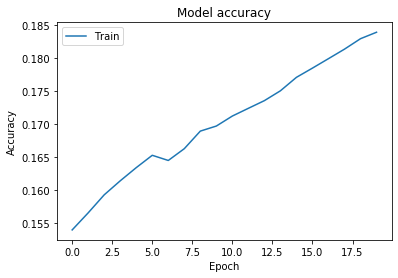

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


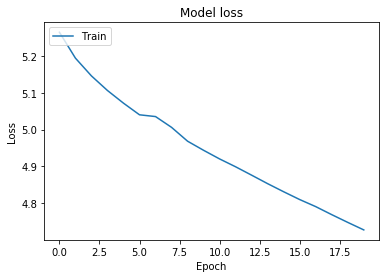

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save Model

In [17]:
# save the model to file
lstm_model.save(ROOT+'/'+str(epochs)+'_epochs_republic_model.h5')
# save the tokenizer
dump(tokenizer, open(ROOT+'/republic_tokenizer.pkl', 'wb'))

## Use Language Model

### Load Data

In [11]:
# # load cleaned text sequences
# in_filename = ROOT+'/republic_sequences.txt'
# doc = load_doc(in_filename)
# lines = doc.split('\n')

### Load Saved Model and Tokenizer

In [34]:
# # load the model
# model = load_model(ROOT+'/100_epochs_republic_model.h5')

# # load the tokenizer
# tokenizer = load(open(ROOT+'/republic_tokenizer.pkl', 'rb'))

### Generate Text

In [18]:
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(lstm_model, tokenizer, seq_length, seed_text, 50)
print(generated)

shadow of justice and for that reason it was of use clearly but in reality justice was such as we were describing being concerned however not with the outward man but with the inward which is the true self and concernment of man for the just man does not permit the

other and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and the same and
